In [1]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd

def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])


# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D) # works unless on endpoint


# function to check if point q lies on line segment 'pr'
def onSegment(p, q, r):
    return (q[0] <= max(p[0], r[0]) and q[0] >= min(p[0], r[0]) and
            q[1] <= max(p[1], r[1]) and q[1] >= min(p[1], r[1]))

# function to find orientation of ordered triplet (p, q, r)
# 0 --> p, q and r are collinear
# 1 --> Clockwise
# 2 --> Counterclockwise
def orientation(p, q, r):
    val = (q[1] - p[1]) * (r[0] - q[0]) - \
          (q[0] - p[0]) * (r[1] - q[1])

    # collinear
    if val == 0:
        return 0

    # clock or counterclock wise
    # 1 for clockwise, 2 for counterclockwise
    return 1 if val > 0 else 2


# function to check if two line segments intersect
def doIntersect(points):
    # find the four orientations needed
    # for general and special cases
    o1 = orientation(points[0][0], points[0][1], points[1][0])
    o2 = orientation(points[0][0], points[0][1], points[1][1])
    o3 = orientation(points[1][0], points[1][1], points[0][0])
    o4 = orientation(points[1][0], points[1][1], points[0][1])

    # general case
    if o1 != o2 and o3 != o4:
        return True

    # special cases
    # p1, q1 and p2 are collinear and p2 lies on segment p1q1
    if o1 == 0 and onSegment(points[0][0], points[1][0], points[0][1]):
        return True

    # p1, q1 and q2 are collinear and q2 lies on segment p1q1
    if o2 == 0 and onSegment(points[0][0], points[1][1], points[0][1]):
        return True

    # p2, q2 and p1 are collinear and p1 lies on segment p2q2
    if o3 == 0 and onSegment(points[1][0], points[0][0], points[1][1]):
        return True

    # p2, q2 and q1 are collinear and q1 lies on segment p2q2 
    if o4 == 0 and onSegment(points[1][0], points[0][1], points[1][1]):
        return True

    return False


def generate_segment(start, end, n):
    return np.array([start + (end - start) * t for t in np.linspace(0, 1, n)])

def segments_intersect(p1, p2, p3, p4, eps=1e-12):
    def orient(a, b, c):
        return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

    o1 = orient(p1, p2, p3)
    o2 = orient(p1, p2, p4)
    o3 = orient(p3, p4, p1)
    o4 = orient(p3, p4, p2)

    # general case
    if o1*o2 < 0 and o3*o4 < 0:
        return True

    # collinear checks
    def on_segment(a, b, c):
        return (min(a[0], b[0]) - eps <= c[0] <= max(a[0], b[0]) + eps and
                min(a[1], b[1]) - eps <= c[1] <= max(a[1], b[1]) + eps)

    if abs(o1) < eps and on_segment(p1, p2, p3): return True
    if abs(o2) < eps and on_segment(p1, p2, p4): return True
    if abs(o3) < eps and on_segment(p3, p4, p1): return True
    if abs(o4) < eps and on_segment(p3, p4, p2): return True

    return False


EPS = 1e-9

def on_segment(p, a, b):
    """Check if p lies on segment ab (including collinear interior)"""
    cross = np.cross(b - a, p - a)
    if abs(cross) > EPS:
        return False
    dot = np.dot(p - a, b - a)
    if dot < 0 or dot > np.dot(b - a, b - a):
        return False
    return True


def generate_segments(
    n_segments=50,
    bounds=(0.0, 1.0),
    max_tries=100000
):
    segments = []
    endpoints = []

    lo, hi = bounds
    tries = 0

    while len(segments) < n_segments and tries < max_tries:
        tries += 1

        A = np.random.uniform(lo, hi, 2)
        B = np.random.uniform(lo, hi, 2)

        # Reject very short segments
        if np.linalg.norm(A - B) < 0.05:
            continue

        # Endpoint uniqueness
        if any(np.linalg.norm(A - p) < EPS or np.linalg.norm(B - p) < EPS for p in endpoints):
            continue

        # No endpoint on any existing segment
        bad = False
        for C, D in segments:
            if on_segment(A, C, D) or on_segment(B, C, D):
                bad = True
                break

        if bad:
            continue

        # Accept segment
        segments.append((A, B))
        endpoints.extend([A, B])

    if len(segments) < n_segments:
        raise RuntimeError("Could not generate enough valid segments")

    return np.array(segments)


def compute_voronoi(points: np.ndarray, data):

    vor = Voronoi(points)  # calculate the voronoi diagram using Scipy 

    fig = voronoi_plot_2d(vor, show_points=False, show_vertices=False)  # create initial figure
    
    # get figure limits for later plotting
    xl, xu = fig.axes[0].get_xlim()
    yl, yu = fig.axes[0].get_ylim()
    plt.show()  # need to do to create new fig

    # get segments from plot
    ax = fig.axes[0]
    segments = ax.collections[0].get_segments()

    # create a reshaped version for indexing
    # for each segment, check if it intersects any of the 
    for seg in segments:
        ((x0, y0), (x1, y1)) = seg

        intersect_list = [
            segments_intersect(
                (x0, y0), (x1, y1),
                tuple(i[0]), tuple(i[1])
            )
            for i in data
        ]
        # intersect_list = [intersect((x0, y0), (x1, y1), i[0], i[1]) for i in data]
        if not any(intersect_list):
            plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)


    # plot the remaining voronoi edges
    segments = ax.collections[1].get_segments()
    for seg in segments:
        ((x0, y0), (x1, y1)) = seg
        plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)

    
    for i in data:
        plt.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], color="tab:blue")

    plt.title('Approximated Voronoi Diagram for a Line Segment')
    plt.xlim(xl, xu)
    plt.ylim(yl, yu)
    plt.show()

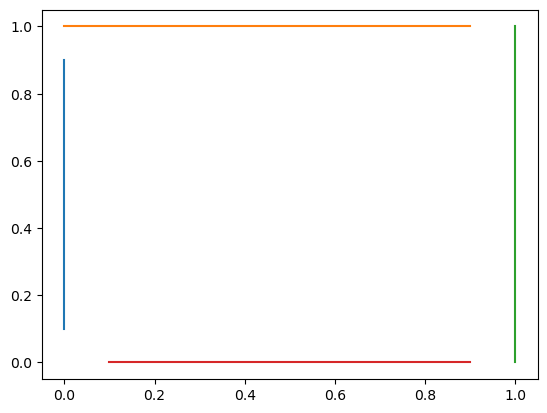

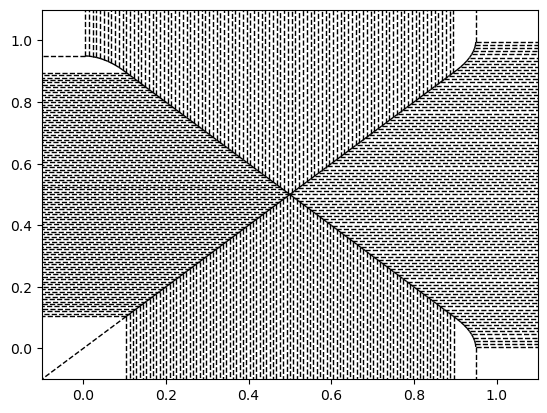

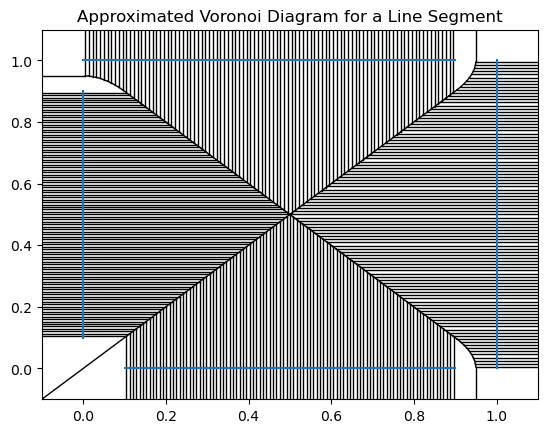

In [58]:
data = pd.read_csv("square.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

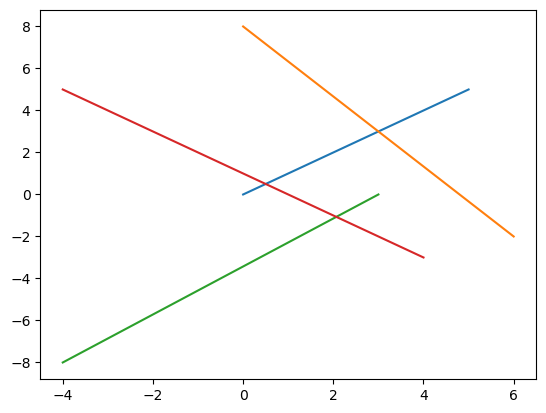

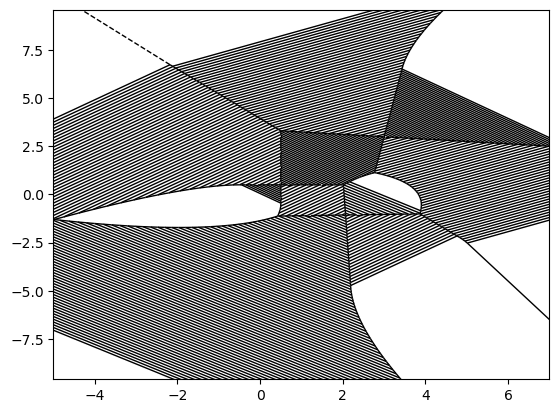

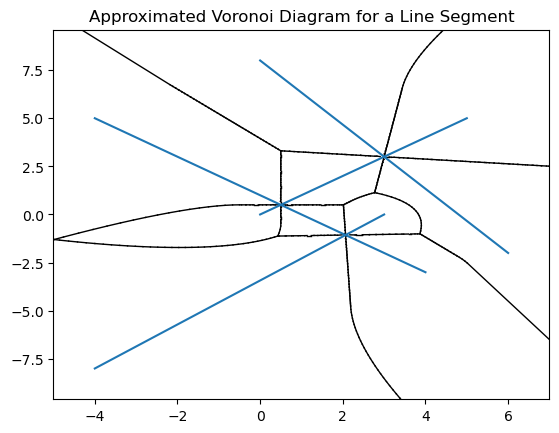

In [59]:
data = pd.read_csv("test.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

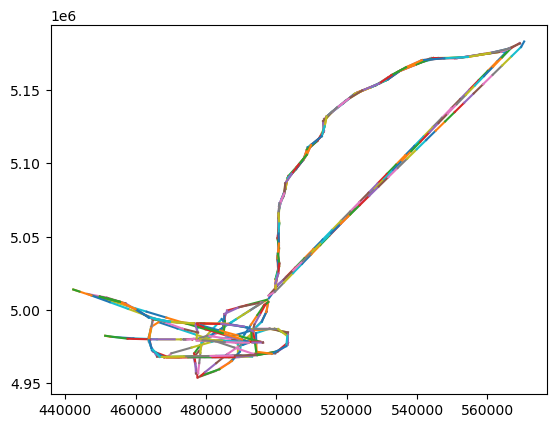

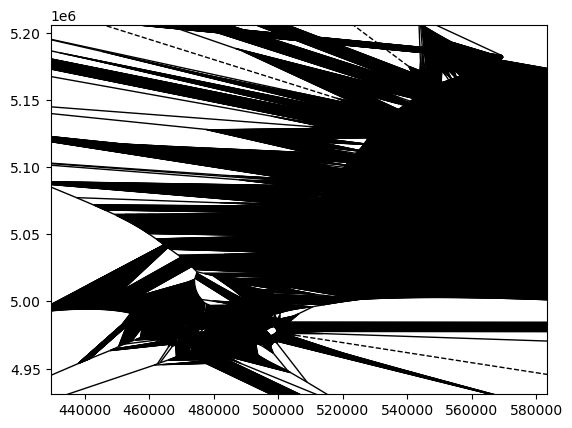

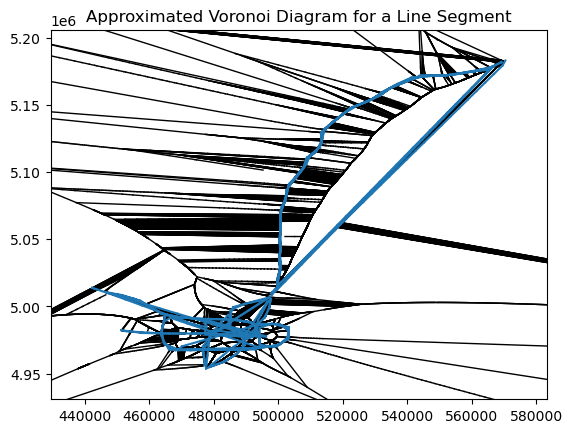

In [6]:
data = pd.read_csv("statesegments_meters.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

In [11]:
def plotfilaments(seg, dim=2, ax=None):
    if dim == 3:
        for j in range(len(seg)):
            ax.plot([seg["U0"].iloc[j], seg["V0"].iloc[j]], [seg["U1"].iloc[j], seg["V1"].iloc[j]], [seg["U2"].iloc[j], seg["V2"].iloc[j]], color="tab:grey", alpha=0.5)
        return
    
    else:
        for j in range(len(seg)):
            plt.plot([seg["U0"].iloc[j], seg["V0"].iloc[j]], [seg["U1"].iloc[j], seg["V1"].iloc[j]], color="tab:grey", alpha=0.5)
        return

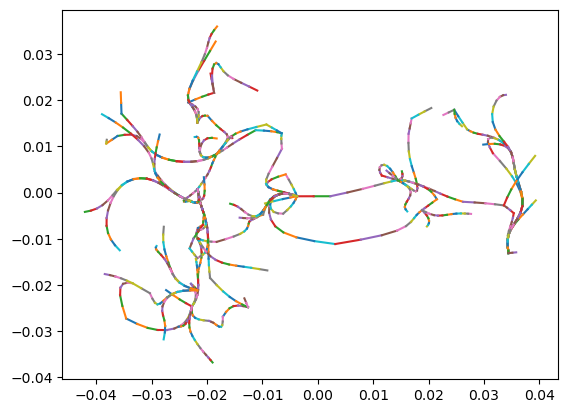

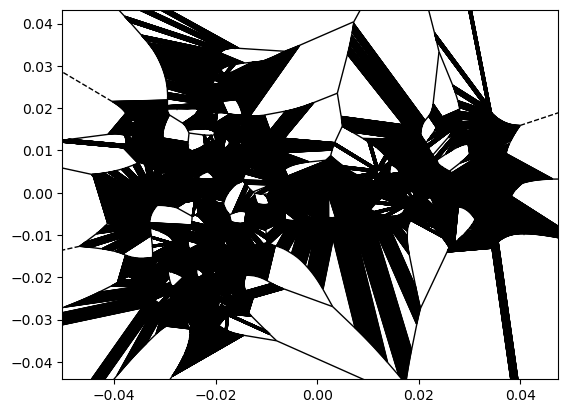

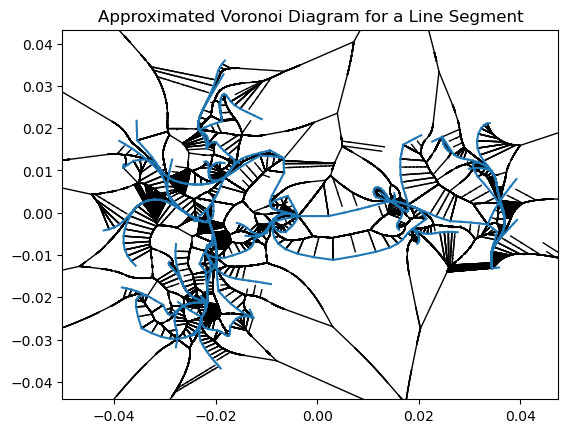

In [2]:
data = pd.read_csv(f"galaxies.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100

data = data[["x1", "y1", "x2", "y2"]].to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

C:\Users\qwert\AppData\Local\Temp\ipykernel_10244\1871458387.py:104: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(b - a, p - a)


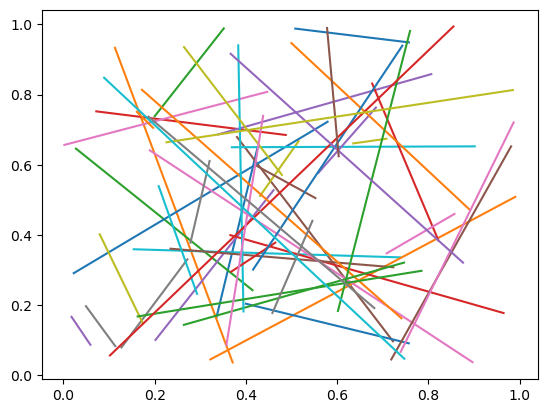

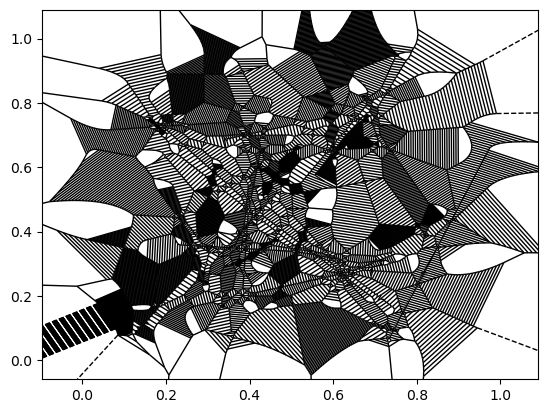

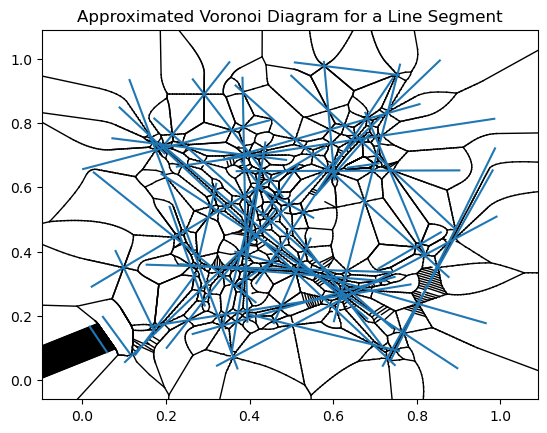

In [72]:
segments = generate_segments(n_segments=50)
data = pd.DataFrame(segments.reshape(len(segments), 4), columns=["x1", "y1", "x2", "y2"])
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)

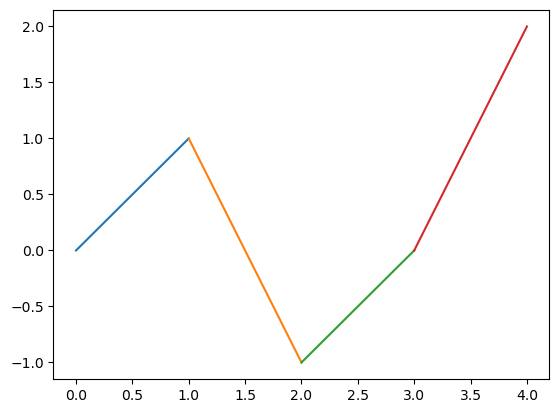

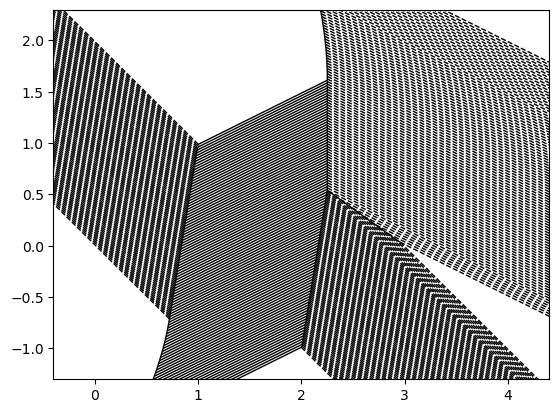

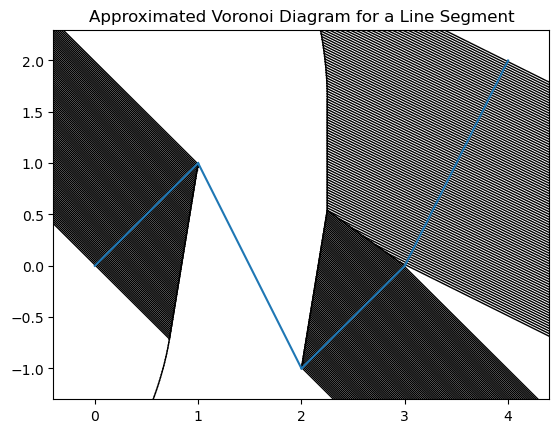

In [73]:
data = pd.read_csv("line.csv")
for i in range(len(data)):
    plt.plot([data.iloc[i]["x1"], data.iloc[i]["x2"]], [data.iloc[i]["y1"], data.iloc[i]["y2"]])
num_points = 100
data = data.to_numpy().reshape(len(data),2,2)  # add additional axis to split data into start and endpoints
segs = [generate_segment(i[0], i[1], num_points) for i in data]
segs = np.vstack(segs)
compute_voronoi(segs, data)